In [11]:
!pip install lifelines


  Obtaining dependency information for lifelines from https://files.pythonhosted.org/packages/cc/95/35190b276a598b640e04e96bcee19362884835c01994db7323d443017e60/lifelines-0.27.8-py3-none-any.whl.metadata
  Obtaining dependency information for autograd>=1.5 from https://files.pythonhosted.org/packages/81/70/d5c7c2a458b8be96495c8b1634c2155beab58cbe864b7a9a5c06c2e52520/autograd-1.6.2-py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for formulaic>=0.2.2 from https://files.pythonhosted.org/packages/ae/f0/ff275c0009f0037c381c6e3a94049b9792df7d7f437c5ccd0c7aefca5f22/formulaic-0.6.6-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/350.7 kB ? eta -:--:--
   ---------------------------------------- 350.7/350.7 kB ? eta 0:00:00
   ---------------------------------------- 0.0/49.3 kB ? eta -:--:--
   ---------------------------------------- 49.3/49.3 kB ? eta 0

In [4]:
import pandas as pd
import numpy as np

data = pd.read_csv('IFR_Extract_with_selected_columns_15-5-23.csv')

obreak_date = pd.to_datetime(data.obreak_date)
datebone = pd.to_datetime(data.datebone)
y = ( abs( datebone - obreak_date))
X = pd.DataFrame({
    "PatientAge": data.PatientAge,
    "PatientGender": data.PatientGender,
    
})
y
data['fxworried'].value_counts()

1.0    388
0.0    201
2.0     91
3.0     10
Name: fxworried, dtype: int64

In [5]:

# X = data.drop(['PostalCode','DateSurveyed','obreak_date','datebone','obone_text','rxother_text'
# ,'rx2_other_text','norxo_text','obone_text','obreak_obone_text'],axis=1)

dropList = []
for i in data:
    if data[i].dtypes == 'O':
        dropList.append(data[i].name)
dropList.append("CompletedSurveyId")
dropList.append("PatientId")
X = data.drop(dropList,axis=1)
X.fillna(0,inplace=True)
y = pd.DataFrame({"time":y})


In [6]:
y.time

y['event'] = y.time.apply(lambda x: x.days != 0 )
structured_array = y.to_records(index=False)

swapped = pd.DataFrame({
    "event": y.event,
    "time": y.time.apply(lambda x: x.days)
})
(swapped.time < 100).value_counts()

False    751
True      49
Name: time, dtype: int64

In [7]:
swapped.event = swapped.event.astype(bool)
swapped.event
structured_array = np.rec.array(swapped.to_records(index=False))
X['specialistReferral'].value_counts()


3     346
8     233
6      73
9      51
7      49
5      35
4       6
10      4
2       3
Name: specialistReferral, dtype: int64

In [12]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index

X_train, X_test, y_train, y_test = train_test_split(X, structured_array, test_size=0.2, random_state=42)

# Create an instance of the RandomSurvivalForest model
model = RandomSurvivalForest(random_state=10)

# Fit the model on the training data
model.fit(X_train, y_train)

# Calculate the baseline performance
baseline_score = concordance_index(y_test['time'], -model.predict(X_test), y_test['event'])

# Initialize an array to store the feature importances
feature_importances = np.zeros(X_train.shape[1])

# Perform feature importance calculation
for i in range(X_train.shape[1]):
    # Make a copy of the test set
    X_permuted = X_test.copy()

    # Permute the values of the feature at index i
    X_permuted.iloc[:, i] = np.random.permutation(X_permuted.iloc[:, i])

    # Calculate the permuted score
    permuted_score = concordance_index(y_test['time'], -model.predict(X_permuted), y_test['event'])

    # Calculate the feature importance as the difference between the baseline score and permuted score
    feature_importances[i] = baseline_score - permuted_score

# Normalize the feature importances
feature_importances /= np.sum(feature_importances)

# Print the feature importances
feature_names = X_train.columns

#for feature_name, importance in zip(feature_names, feature_importances):
    #print(f"Feature: {feature_name}, Importance: {importance}")

df = pd.DataFrame()
for name, importance in zip(feature_names, feature_importances):
    df = pd.concat([df, pd.DataFrame({'Feature Name': [name], 'Feature Importance': [importance]})], ignore_index=True)

df = df.sort_values('Feature Importance', ascending=False)

df

# Calculate the c-index on the test set
c_index = concordance_index(y_test['time'], -model.predict(X_test), y_test['event'])
print("C-index:", c_index)



C-index: 0.6084361642067909


In [13]:
deleted_columns = []
cutoff = 0.1
while(len(deleted_columns) < 180):
        deleted_columns = []
        for i in range(len(feature_importances)):
                if feature_importances[i] >= 0 and feature_importances[i] < cutoff:
                        deleted_columns.append(feature_names[i])    
                elif feature_importances[i] < 0 and feature_importances[i] > -cutoff:
                        deleted_columns.append(feature_names[i]) 
        cutoff += 0.1
X = data.drop((deleted_columns + dropList),axis=1)

X = X.fillna(0)


In [14]:
X

,ptfall,ptunsteady,obreaK_wrist,obreak_hip,marital,fs_yg2sb
0,1,0,1.0,0.0,2.0,0.0
1,1,1,0.0,1.0,6.0,1.0
2,0,0,1.0,0.0,2.0,1.0
3,0,0,1.0,0.0,6.0,1.0
4,1,1,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
795,1,0,1.0,0.0,0.0,0.0
796,0,1,1.0,0.0,2.0,1.0
797,0,0,0.0,0.0,0.0,0.0
798,0,0,0.0,0.0,0.0,0.0


In [15]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X, structured_array)

# Calculate the c-index on the test set
c_index = concordance_index(structured_array['time'], -estimator.predict(X), structured_array['event'])
print("C-index:", c_index)

C-index: 0.6277788776559396


In [16]:
pd.Series(estimator.coef_, index=X.columns)


ptfall          0.392841
ptunsteady     -0.062045
obreaK_wrist   -0.279201
obreak_hip      0.290443
marital        -0.037164
fs_yg2sb       -0.196481
dtype: float64

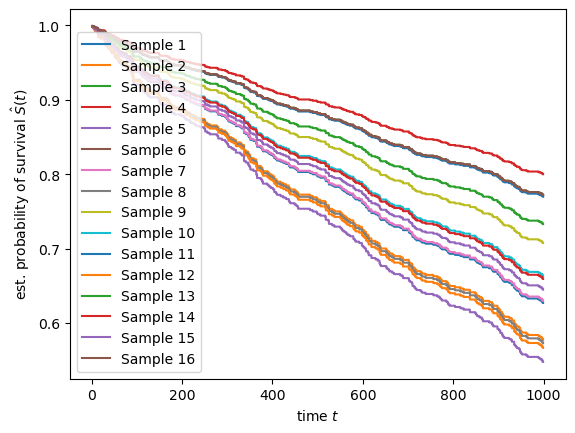

In [17]:
import matplotlib.pyplot as plt

pred_surv = estimator.predict_survival_function(X.loc[:15])
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")